# Setup

Download the dataset from:<br>
https://drive.google.com/drive/folders/1oErX5yyCVNwuRNXayIdXwdD5EomZk16s?usp=sharing<br><br>
Get COLMAP from this link (windows-no-cuda), extract it and save it in a new folder called 'Colmap':<br>
https://github.com/colmap/colmap/releases/tag/3.6<br><br>
Before running, check that your folder structure looks like:<br>
<ul>
<li>Final Code.ipynb</li>
<li>Colmap</li>
<li>Models</li>
<li>Req</li>
<li>Utils</li>
</ul>

# Monte Carlo Localization Method

In [1]:
import numpy as np
import scipy
import cv2
from sklearn.cluster import KMeans
import os
import pandas as pd
import Utils.ConvNet as ConvNet
import Utils.Video as Video
import pickle

import matplotlib.pyplot as plt

In [2]:
class Particle:
    def __init__(self, location, movement_map, weight, index):
        self.location = tuple(location)
        self.movement_map = movement_map
        self.weight = weight
        self.index = int(index)
        
    def move(self, d_scale=4, v_scale=.2):
        possible_locations = list(self.movement_map.keys())
        #Find closest value in movement map
        distances = scipy.spatial.distance.cdist([self.location], possible_locations)
        
        key = possible_locations[np.argmin(distances[0])]
        
        start = np.array(key)
        end = np.array(movement_map[key]) + np.random.normal(size=2, scale=v_scale)
        
        
        d = scipy.spatial.distance.euclidean(start, end) + np.random.normal(scale=d_scale)
        a = self.calculate_initial_compass_bearing(tuple(start), tuple(end))

        x2 = start[0] + d*np.sin(a)
        y2 = start[1] + d*np.cos(a)
        
        self.location = (x2, y2)
        
        
    def calculate_initial_compass_bearing(self, pointA, pointB):
        
        delta_x = pointB[0] - pointA[0]
        delta_y = pointB[1] - pointA[1]        

        theta = np.degrees(np.arctan2(np.abs(delta_y), np.abs(delta_x)))
        
        if ((delta_x < 0) & (delta_y > 0)):
            theta += 270
        elif ((delta_x < 0) & (delta_y < 0)):
            theta = 270 - theta
        elif ((delta_x > 0) & (delta_y < 0)):
            theta += 90
        else:
            theta = 90 - theta

        return np.radians(theta)

In [3]:
def create_particles(n, possible_locations, weightings, movement_map):
    indicies = range(len(possible_locations))
    particles = [Particle(possible_locations[j], movement_map, 1/n, j) for i, j in enumerate(np.random.choice(indicies, replace=True, size=n, p=weightings))]
    return particles

In [5]:
def load_images(loc, dataset_loc="../Dataset"):
    df = pd.read_csv(loc, sep=' ', names=['location', 'x', 'y', 'z'])
    df['location'] = df['location'].apply(lambda x: os.path.join(dataset_loc, x))
    df['location'] = df['location'].apply(lambda x: x.replace('\\', '/'))
    return df

In [6]:
def calculate_tpr(labels, y_test, maxi=100):
    thresholds = np.linspace(0, maxi, num=100)
    tprs = np.array([])

    for thre in thresholds:
        tpr = 0
        for i in range(len(labels)):
            difference = scipy.spatial.distance.euclidean(labels[i], y_test[i])
            if (difference < thre):
                tpr += 1

        tprs = np.append(tprs, tpr/len(labels))
        
    return tprs, thresholds

In [7]:
def calculate_average_position(locations, weights, movement_map, thr=1):
    return np.average(locations, weights=weights, axis=0)

In [8]:
def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats, metric='braycurtis'):

    distances = scipy.spatial.distance.cdist(test_image_feats, train_image_feats, metric)   
        
    return 1 - (distances/np.max(distances))

In [9]:
def build_vocabulary(image_paths, vocab_size, detector_function, params, dim, mask=None, grayed=True, dimentionality_reduction=False):

    features = np.array([]).reshape((-1, dim))
    
    # Initiate detector
    detector = detector_function(**params)
    
    for i, path in enumerate(image_paths):
        
        if grayed:
            image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        else:
            image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        
        if mask is not None:
            image = cv2.bitwise_and(image, image, mask = mask)

        # compute the descriptors      
        kps, des = detector.detectAndCompute(image, None)
    
        
        if not des is None:
            features = np.vstack([features, des])
            
            
    if dimentionality_reduction == True:
        features, trans = ConvNet.dimentionalityReduction(features)
        
        #Do clustering
        km = KMeans(n_clusters=vocab_size).fit(features)
        
        return km.cluster_centers_, trans
    
    else:      

        #Do clustering
        km = KMeans(n_clusters=vocab_size).fit(features)

        return km.cluster_centers_

In [10]:
def get_bags_of_words(image_paths, detector_function, params, mask=None, grayed=True, transformer=None, vocab_file='vocab.npy', max_features=1000, pyramid_levels=2):
    
    # load vocabulary
    vocab = np.load(vocab_file)
    
    # dummy features variable
    features = np.array([]).reshape(-1, len(vocab) * sum(int(4**i) for i in range(0, pyramid_levels)))
    
    # Initiate detector
    detector = detector_function(**params)

    for path in image_paths:
        image_hist = np.array([])        
        
        if type(path) == str:
            #Loads in image
            if grayed:
                image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
            else:
                image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        else:
            image = path
            

        for i in range(1, pyramid_levels + 1):
            subdivisions = int((2**i)/2)
            
            for j in range(0, subdivisions):
                for k in range(0, subdivisions):
                    height = (image.shape[0]//subdivisions)
                    width = (image.shape[1]//subdivisions)
                    
                    #Get the part of the image to calculate on
                    level = image[(j * height):((j + 1) * height), (k * width):((k + 1) * width)]
                    hist = np.zeros((len(vocab)))
            
                    # compute the descriptors
                    kps, des = detector.detectAndCompute(image, None)

                    if not transformer is None:
                        des = transformer.transform(des)

                    if not des is None:
                        try:
                            sorted_descriptions = sorted(zip(des,kps), key=lambda x: x[1].response)[:max_features]
                        except:
                            sorted_descriptions = list(zip(des,kps))[:max_features]

                        for feature, kp in sorted_descriptions:
                            distances = scipy.spatial.distance.cdist([feature], vocab, 'cosine')
                            i = np.argmin(distances[0])

                            hist[i] += 1
                    
                    image_hist = np.append(image_hist, hist)
            
        features = np.vstack([features, image_hist])
        
    return features

In [11]:
def calculate_movement_per(loc1, loc2, movement_map):
    possible_locations = list(movement_map.keys())
    #Find closest value in movement map
    distances = scipy.spatial.distance.cdist([loc1], possible_locations)

    key = possible_locations[np.argmin(distances[0])]

    start = np.array(key)
    end = np.array(movement_map[key])


    d1 = scipy.spatial.distance.euclidean(start, end)
    d2 = scipy.spatial.distance.euclidean(loc1, loc2)

    return d2/d1

## First Time Setup

In [13]:
#Point dataset_loc to the relative path of the dataset you downloaded at the start
images = load_images('./Req/movement_map_locations.txt', dataset_loc='../Dataset')
movement_map = {}

for i, row in images.iterrows():
    if not i >= len(images)-1:
        next_row = images.iloc[i+1]
        movement_map[(row['x'], row['y'])] = (next_row['x'], next_row['y'])
        
with open('Models/movement_map.pickle', 'wb') as handle:
    pickle.dump(movement_map, handle)

## Running

In [12]:
#Point this to the directory of the dataset downloaded from https://drive.google.com/drive/folders/1oErX5yyCVNwuRNXayIdXwdD5EomZk16s?usp=sharing
images = load_images('../Dataset/Locations/locations.txt', dataset_loc='../Dataset')

X_train, y_train = images['location'], list(zip(images['x'], images['y']))

In [13]:
params = dict(nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=7, sigma=1.8)
train_image_feats = get_bags_of_words(X_train, cv2.SIFT_create, params, vocab_file='./Models/vocab-sift-1000.npy')

with open('Models/movement_map.pickle', 'rb') as handle:
    movement_map = pickle.load(handle)

In [14]:
def main(video, localized_points=None, iterations=5, radius_thre=6, d_scale=4, v_scale=.2):
    X_test, y_test = Video.load_video_to_frames(video, step=6)
    
    test_image_feats = get_bags_of_words(X_test, cv2.SIFT_create, params, vocab_file='./Models/vocab-sift-1000.npy')
    
    #Create a threshold to know what counts as an important particle

    #Test images
    test_images = X_test

    #All locations of train images
    possible_locations = y_train

    #Initialize Particles randomly
    n_particles = 50

    best_roc = 0
    best_locations = None
    
    for x in range(iterations):
        location = []
        
        #particles = create_particles(200, possible_locations, np.full(len(possible_locations), 1/len(possible_locations)), movement_map)
        particles = create_particles(100, [[249.0, 173.0]], [1], movement_map)

        for i in range(0, len(test_images[:])):

            #Motion update
            for particle in particles:
                particle.move(d_scale=d_scale, v_scale=v_scale)



            #Sensor update, pass image through image retrieval to get probability weightings
            weightings = nearest_neighbor_classify(train_image_feats, y_train, [test_image_feats[i]])[0]

            particle_weights = np.array([])

            for particle in particles:
                useful = weightings[scipy.spatial.distance.cdist([particle.location], np.array(possible_locations))[0] < radius_thre]

                if (len(useful) > 0):
                    particle_weights = np.append(particle_weights, (np.sum(useful)/len(useful)))
                else:
                    particle_weights = np.append(particle_weights, 0.0000001)

            #Robust likelyhood equation


            particle_weights = particle_weights/np.sum(particle_weights)


            #Calculate average position and weightings
            locations = np.array([]).reshape(-1,2)
            weights = np.array([])
            indexes = np.array([])
            for particle in particles:
                locations = np.vstack([locations, particle.location])
                weights = np.append(weights, particle.weight)
                indexes = np.append(indexes, particle.index)



            location.append(calculate_average_position(locations, particle_weights, movement_map))


            #Select strong particles
            particles = create_particles(n_particles, locations, particle_weights, movement_map)       


        if localized_points is None:
            localized_points = np.arange(len(y_test))

        t, r = calculate_tpr(np.array(location)[localized_points], np.array(y_test)[localized_points], maxi=20)
        
        if (best_roc < t[50]):
            best_locations = location
            
    return best_locations, y_test

# Crash Videos

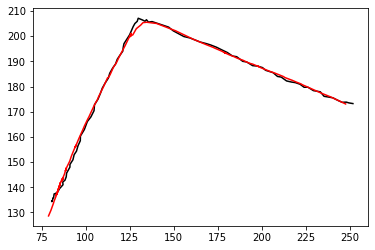

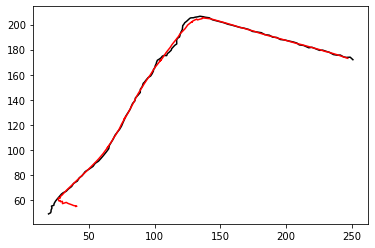

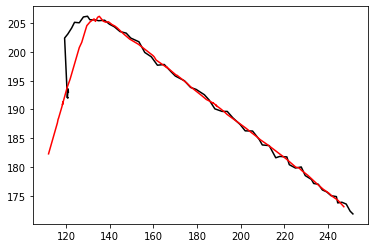

[0.         0.         0.         0.01052632 0.02398534 0.02749411
 0.02749411 0.0415292  0.04503797 0.0475825  0.06709482 0.08055384
 0.08818743 0.09932979 0.12782812 0.14089896 0.15555009 0.16511217
 0.20436468 0.21890187 0.24010842 0.25719014 0.27670247 0.2913536
 0.31290834 0.33049218 0.34163454 0.34660966 0.35617173 0.36720016
 0.38173736 0.40221392 0.43626344 0.45481152 0.47285749 0.50740912
 0.52437691 0.54886436 0.55989278 0.56594608 0.58156146 0.59112353
 0.59960743 0.61510887 0.61861764 0.63558543 0.6475781  0.65255322
 0.65860653 0.65860653 0.67071313 0.67676643 0.67931096 0.68185549
 0.69542844 0.70402627 0.7090014  0.72353859 0.7295919  0.73807579
 0.74158456 0.74763787 0.74763787 0.74763787 0.7562357  0.77331742
 0.77829255 0.7858122  0.79333185 0.80944934 0.82194412 0.82946377
 0.84315066 0.84315066 0.84812578 0.85310091 0.85564544 0.86062056
 0.86062056 0.86316509 0.87068474 0.8757738  0.88340739 0.88849645
 0.89613004 0.89867457 0.89867457 0.90619422 0.90619422 0.90873

In [15]:
videos = ['../Dataset/Videos/crash#1.mp4', '../Dataset/Videos/crash#2.mp4', '../Dataset/Videos/crash#3.mp4']
localized_points = [[0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  36,  37,  39,  40,  44,  45,  46,  47,  48,  49,  50,  51,  52,  55,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  101,  102],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]]
vals = np.array([]).reshape(-1, 100)

for i,video in enumerate(videos):    

    location, y_test = main(video, localized_points=np.array(localized_points[i]), iterations=10, radius_thre=8, d_scale=3, v_scale=0.1)

    t, r = calculate_tpr(np.array(location)[np.array(localized_points[i])], np.array(y_test)[np.array(localized_points[i])], maxi=20)

    plt.plot(np.array(y_test)[np.array(localized_points[i]),0], np.array(y_test)[np.array(localized_points[i]),1], c='black')
    plt.plot(np.array(location)[np.array(localized_points[i]),0], np.array(location)[np.array(localized_points[i]),1], c='red')
    plt.show()

    vals = np.vstack([vals, t])
    
print(np.mean(vals, axis=0))

# Dry Race

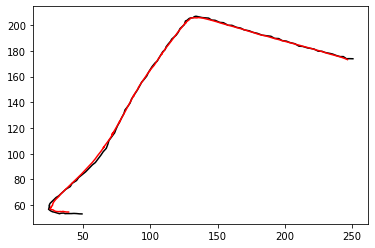

[0.    0.    0.032 0.048 0.048 0.048 0.056 0.08  0.08  0.088 0.096 0.128
 0.152 0.152 0.176 0.216 0.24  0.256 0.272 0.304 0.32  0.344 0.352 0.392
 0.416 0.448 0.464 0.48  0.504 0.52  0.536 0.56  0.592 0.616 0.64  0.648
 0.656 0.656 0.656 0.672 0.672 0.672 0.68  0.68  0.68  0.68  0.688 0.688
 0.696 0.72  0.744 0.744 0.744 0.752 0.76  0.76  0.768 0.784 0.792 0.8
 0.8   0.808 0.808 0.808 0.816 0.824 0.824 0.824 0.824 0.832 0.832 0.832
 0.832 0.832 0.832 0.832 0.832 0.832 0.832 0.832 0.832 0.832 0.832 0.84
 0.84  0.84  0.84  0.84  0.84  0.848 0.848 0.848 0.848 0.848 0.848 0.848
 0.848 0.856 0.856 0.856]


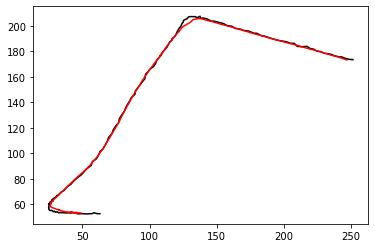

[0.         0.         0.01342282 0.02684564 0.04026846 0.05369128
 0.0738255  0.10738255 0.12080537 0.14765101 0.18120805 0.18791946
 0.20805369 0.22818792 0.28187919 0.29530201 0.31543624 0.33557047
 0.3557047  0.36241611 0.39597315 0.4295302  0.46308725 0.48322148
 0.4966443  0.51006711 0.52348993 0.53020134 0.55704698 0.5704698
 0.59060403 0.60402685 0.60402685 0.60402685 0.61073826 0.61744966
 0.62416107 0.6442953  0.65100671 0.65771812 0.67785235 0.7114094
 0.73825503 0.73825503 0.74496644 0.75167785 0.77852349 0.79194631
 0.79865772 0.79865772 0.79865772 0.81208054 0.83221477 0.83221477
 0.83892617 0.84563758 0.85234899 0.86577181 0.87919463 0.89932886
 0.90604027 0.91275168 0.91275168 0.91946309 0.93959732 0.93959732
 0.93959732 0.93959732 0.93959732 0.95302013 0.95973154 0.95973154
 0.95973154 0.95973154 0.95973154 0.95973154 0.95973154 0.95973154
 0.96644295 0.97315436 0.97986577 0.97986577 0.97986577 0.97986577
 0.98657718 0.98657718 0.98657718 0.99328859 1.         1.
 1.  

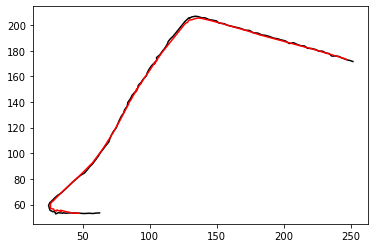

[0.         0.00746269 0.01492537 0.02985075 0.05223881 0.07462687
 0.15671642 0.17910448 0.20895522 0.25373134 0.29104478 0.3358209
 0.34328358 0.36567164 0.3880597  0.41791045 0.43283582 0.45522388
 0.47761194 0.49253731 0.49253731 0.5        0.52238806 0.54477612
 0.56716418 0.58955224 0.60447761 0.6119403  0.61940299 0.61940299
 0.63432836 0.64179104 0.64179104 0.64179104 0.64179104 0.64925373
 0.64925373 0.65671642 0.67164179 0.67910448 0.68656716 0.70149254
 0.70895522 0.71641791 0.7238806  0.73134328 0.73134328 0.73880597
 0.74626866 0.75373134 0.76119403 0.76119403 0.76119403 0.76119403
 0.76865672 0.76865672 0.79104478 0.79104478 0.79850746 0.79850746
 0.79850746 0.80597015 0.80597015 0.80597015 0.80597015 0.80597015
 0.80597015 0.80597015 0.80597015 0.80597015 0.81343284 0.81343284
 0.81343284 0.82089552 0.82835821 0.8358209  0.8358209  0.84328358
 0.84328358 0.84328358 0.84328358 0.84328358 0.84328358 0.84328358
 0.84328358 0.84328358 0.84328358 0.84328358 0.84328358 0.85074

In [16]:
videos = ['../Dataset/Videos/dry-race#1.mp4', '../Dataset/Videos/dry-race#2.mp4', '../Dataset/Videos/dry-race#3.mp4']
localized_points = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 116, 117, 118, 119, 122, 123, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145]]

vals = np.array([]).reshape(-1, 100)

for i,video in enumerate(videos):
    location, y_test = main(video, localized_points=np.array(localized_points[i]), iterations=20, radius_thre=8, d_scale=2, v_scale=0.1)

    t, r = calculate_tpr(np.array(location)[np.array(localized_points[i])], np.array(y_test)[np.array(localized_points[i])], maxi=20)

    plt.plot(np.array(y_test)[np.array(localized_points[i]),0], np.array(y_test)[np.array(localized_points[i]),1], c='black')
    plt.plot(np.array(location)[np.array(localized_points[i]),0], np.array(location)[np.array(localized_points[i]),1], c='red')
    plt.show()
    
    print(t)
    
    vals = np.vstack([vals, t])
    
print(np.mean(vals, axis=0))

# Vary Speed

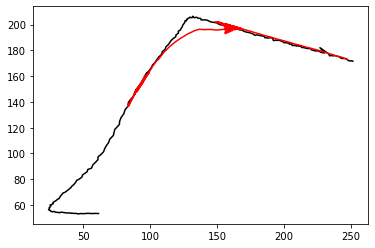

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00436681 0.00436681 0.00436681
 0.00436681 0.00436681 0.00436681 0.00873362 0.01310044 0.01310044
 0.01746725 0.02183406 0.02183406 0.02620087 0.0349345  0.04366812
 0.04366812 0.04366812 0.04803493 0.04803493 0.04803493 0.04803493
 0.04803493 0.04803493 0.05240175 0.05240175 0.06113537 0.06550218
 0.06550218 0.06550218 0.069869   0.069869   0.08733624 0.09170306
 0.09170306 0.09606987 0.10917031 0.11353712 0.11353712 0.12227074
 0.12227074 0.12227074 0.12663755 0.12663755 0.13100437 0.13100437
 0.13100437 0.13100437 0.13100437 0.13973799 0.13973799 0.1441048
 0.14847162 0.15283843 0.15283843 0.15283843 0.15283843 0.15720524
 0.16593886 0.16593886 0.17467249 0.17467249 0.1790393  0.1790393
 0.18340611 0.18340611 0.18340611 0.18777293 0.20087336 0.20524017
 0.20960699 0.21834061 0.21834061 0.21834061 0.21834061 0.21834061
 0.21834061 0.23144105 0.23580786 0.23580786 0.23580786 0.23580786
 0.24

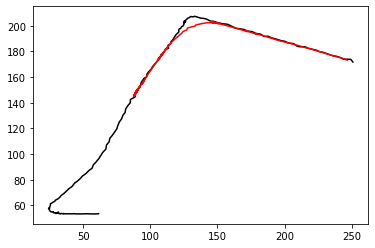

[0.         0.         0.         0.         0.         0.
 0.00487805 0.00487805 0.00487805 0.01463415 0.01463415 0.01463415
 0.01463415 0.01463415 0.01463415 0.02439024 0.02926829 0.03414634
 0.03902439 0.03902439 0.04390244 0.04390244 0.04390244 0.05365854
 0.05853659 0.05853659 0.05853659 0.06341463 0.06829268 0.08292683
 0.08780488 0.08780488 0.09756098 0.10243902 0.10731707 0.11219512
 0.12195122 0.12682927 0.12682927 0.13658537 0.14634146 0.16097561
 0.16097561 0.16097561 0.16097561 0.16585366 0.16585366 0.16585366
 0.17073171 0.17073171 0.17073171 0.17073171 0.17073171 0.17560976
 0.17560976 0.17560976 0.1804878  0.19512195 0.19512195 0.2
 0.2        0.2        0.2        0.2        0.2097561  0.2195122
 0.23414634 0.23414634 0.23902439 0.25365854 0.25853659 0.26829268
 0.26829268 0.27317073 0.27804878 0.28292683 0.28780488 0.29268293
 0.30243902 0.31219512 0.31219512 0.31219512 0.31219512 0.31707317
 0.32195122 0.32682927 0.32682927 0.33170732 0.33170732 0.33170732
 0.33170732

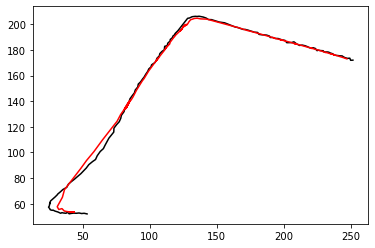

[0.         0.         0.         0.00606061 0.01212121 0.01212121
 0.03030303 0.04242424 0.04242424 0.04848485 0.04848485 0.04848485
 0.06060606 0.06666667 0.07878788 0.07878788 0.08484848 0.09090909
 0.10909091 0.11515152 0.11515152 0.11515152 0.12121212 0.14545455
 0.14545455 0.15151515 0.16363636 0.18181818 0.18787879 0.21818182
 0.21818182 0.23636364 0.23636364 0.24848485 0.25454545 0.26666667
 0.27878788 0.28484848 0.29090909 0.30909091 0.33939394 0.35151515
 0.36969697 0.37575758 0.37575758 0.38181818 0.38787879 0.38787879
 0.40606061 0.42424242 0.43636364 0.45454545 0.46666667 0.47878788
 0.4969697  0.5030303  0.51515152 0.52121212 0.52727273 0.53333333
 0.53939394 0.55151515 0.56969697 0.58787879 0.59393939 0.59393939
 0.60606061 0.61212121 0.63636364 0.64242424 0.64848485 0.66060606
 0.66060606 0.66666667 0.67272727 0.67878788 0.68484848 0.6969697
 0.6969697  0.6969697  0.71515152 0.71515152 0.71515152 0.71515152
 0.72121212 0.72121212 0.72121212 0.72121212 0.72727273 0.72727

In [102]:
videos = ['../Dataset/Videos/vary-speed#1.mp4', '../Dataset/Videos/vary-speed#2.mp4', '../Dataset/Videos/vary-speed#3.mp4']
localized_points = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 61, 63, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182]]

vals = np.array([]).reshape(-1, 100)

for i,video in enumerate(videos):
    location, y_test = main(video, localized_points=np.array(localized_points[i]), iterations=20, radius_thre=8, d_scale=2, v_scale=0.1)

    t, r = calculate_tpr(np.array(location)[np.array(localized_points[i])], np.array(y_test)[np.array(localized_points[i])], maxi=20)

    plt.plot(np.array(y_test)[np.array(localized_points[i]),0], np.array(y_test)[np.array(localized_points[i]),1], c='black')
    plt.plot(np.array(location)[np.array(localized_points[i]),0], np.array(location)[np.array(localized_points[i]),1], c='red')
    plt.show()

    print(t)
    
    vals = np.vstack([vals, t])
    
print(np.mean(vals, axis=0))

# Wet Race

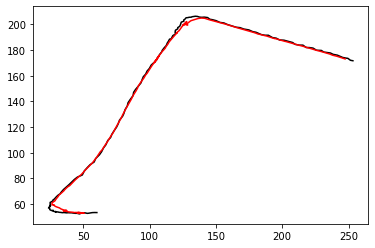

[0.         0.         0.03067485 0.04294479 0.09815951 0.13496933
 0.14110429 0.17791411 0.2392638  0.26380368 0.27607362 0.29447853
 0.32515337 0.34355828 0.35582822 0.36809816 0.38650307 0.39877301
 0.41104294 0.41717791 0.45398773 0.46625767 0.46625767 0.47239264
 0.47852761 0.48466258 0.50306748 0.51533742 0.51533742 0.53374233
 0.54601227 0.55214724 0.56441718 0.56441718 0.56441718 0.57055215
 0.57055215 0.59509202 0.60736196 0.62576687 0.63190184 0.63803681
 0.65644172 0.68711656 0.6993865  0.73006135 0.74233129 0.75460123
 0.76687117 0.78527607 0.79141104 0.80981595 0.82822086 0.84662577
 0.85889571 0.86503067 0.87730061 0.88343558 0.90184049 0.91411043
 0.9202454  0.9202454  0.9202454  0.92638037 0.93251534 0.93865031
 0.93865031 0.93865031 0.94478528 0.94478528 0.95092025 0.96319018
 0.96932515 0.97546012 0.98159509 0.99386503 0.99386503 0.99386503
 0.99386503 0.99386503 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        

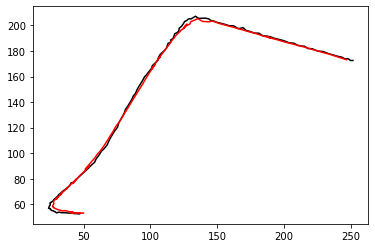

[0.         0.         0.00632911 0.01898734 0.02531646 0.03164557
 0.05063291 0.06329114 0.06962025 0.06962025 0.08227848 0.09493671
 0.11392405 0.11392405 0.11392405 0.15822785 0.17088608 0.1835443
 0.18987342 0.18987342 0.18987342 0.19620253 0.19620253 0.20886076
 0.22151899 0.23417722 0.24683544 0.25949367 0.25949367 0.27848101
 0.27848101 0.29113924 0.29746835 0.29746835 0.29746835 0.29746835
 0.29746835 0.30379747 0.3164557  0.33544304 0.35443038 0.37341772
 0.37341772 0.37974684 0.38607595 0.39240506 0.40506329 0.41139241
 0.41772152 0.43037975 0.43037975 0.43670886 0.44303797 0.46202532
 0.46835443 0.46835443 0.46835443 0.46835443 0.49367089 0.50632911
 0.51898734 0.53164557 0.53797468 0.5443038  0.55696203 0.55696203
 0.56329114 0.58860759 0.59493671 0.60759494 0.62025316 0.62025316
 0.63291139 0.63924051 0.63924051 0.63924051 0.63924051 0.63924051
 0.63924051 0.67088608 0.6835443  0.68987342 0.72151899 0.7278481
 0.7278481  0.73417722 0.73417722 0.74683544 0.74683544 0.753164

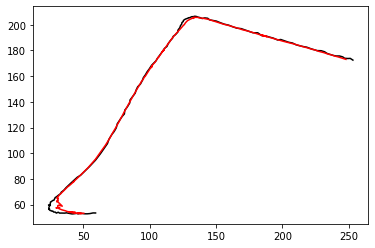

[0.         0.         0.         0.02469136 0.04938272 0.07407407
 0.11728395 0.14197531 0.17283951 0.19753086 0.22222222 0.2345679
 0.2654321  0.2962963  0.31481481 0.32098765 0.32716049 0.34567901
 0.37037037 0.38271605 0.40740741 0.43209877 0.46296296 0.4691358
 0.48765432 0.50617284 0.52469136 0.5308642  0.54320988 0.54320988
 0.55555556 0.56790123 0.58024691 0.58024691 0.59876543 0.61728395
 0.62962963 0.63580247 0.66049383 0.66666667 0.67901235 0.67901235
 0.69753086 0.7037037  0.70987654 0.72222222 0.72839506 0.72839506
 0.7345679  0.7345679  0.74074074 0.74074074 0.74074074 0.75925926
 0.77160494 0.77160494 0.77777778 0.77777778 0.79012346 0.7962963
 0.7962963  0.7962963  0.7962963  0.81481481 0.81481481 0.81481481
 0.82098765 0.82098765 0.82716049 0.82716049 0.83333333 0.84567901
 0.85802469 0.88271605 0.89506173 0.90123457 0.91358025 0.91358025
 0.9382716  0.9382716  0.9382716  0.9382716  0.9382716  0.9382716
 0.94444444 0.94444444 0.94444444 0.94444444 0.94444444 0.95061728

In [18]:
videos = ['../Dataset/Videos/wet-race#1.mp4', '../Dataset/Videos/wet-race#2.mp4', '../Dataset/Videos/wet-race#3.mp4']
localized_points = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161]]

locs = []
orig = []

vals = np.array([]).reshape(-1, 100)

for i,video in enumerate(videos):
    location, y_test = main(video, localized_points=np.array(localized_points[i]), iterations=100, radius_thre=8, d_scale=4, v_scale=0.1)

    t, r = calculate_tpr(np.array(location)[np.array(localized_points[i])], np.array(y_test)[np.array(localized_points[i])], maxi=20)

    plt.plot(np.array(y_test)[np.array(localized_points[i]),0], np.array(y_test)[np.array(localized_points[i]),1], c='black')
    plt.plot(np.array(location)[np.array(localized_points[i]),0], np.array(location)[np.array(localized_points[i]),1], c='red')
    plt.show()

    print(t)
    
    vals = np.vstack([vals, t])
    locs.append(location)
    orig.append(y_test)
    
print(np.mean(vals, axis=0))

# Structure from Motion Method
You need to have ran the function definitions in the previous section to make this work

In [16]:
import numpy as np
import scipy
import cv2
from sklearn.cluster import KMeans
import os
import pandas as pd
import pickle
import shutil
import tempfile
import Utils.read_model as read_model

In [17]:
def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats, metric='braycurtis', k=1):

    distances = scipy.spatial.distance.cdist(test_image_feats, train_image_feats, metric)

    #Setup variables, need to be numpy arrays for array indexing
    train_labels = np.array(train_labels)
    test_labels = np.array([]).reshape(-1,k,2)
    indexes = np.array([]).reshape(-1,k)

    for i in range(len(test_image_feats)):
        
        #For every image get the closest k labels        
        sorted_distances = np.argsort(distances[i])
        closest = train_labels[sorted_distances[:k]]
        
        test_labels = np.vstack([test_labels, [closest]])
        indexes = np.vstack([indexes, sorted_distances[:k]])
        
    return test_labels, indexes

In [18]:
def fine_localization(model_filenames, test_file, locations, directory, max_builds=5):
    #Copy Images to Folder
    
    #shutil.copy(test_file, directory)
    cv2.imwrite('{0}/frame.jpg'.format(directory), cv2.cvtColor(test_file, cv2.COLOR_BGR2RGB))
    
    for image in model_filenames:
        shutil.copy(image, directory)
    
    #Create Locations.txt for geolocalization
    with open("{0}/locations.txt".format(directory), "w") as text_file:
        for i in range(len(model_filenames)):
            text_file.write("{0} {1} {2} 0\n".format(model_filenames[i].split('/')[-1], locations[i][0], locations[i][1]))
    
    
    #Create reconstruction
    builds = 0
    while builds < max_builds:
        #print(builds)
        !call Colmap\colmap.bat automatic_reconstructor --workspace_path $directory --image_path $directory --vocab_tree_path .\Output\vocab-sift-500.npy --single_camera 1 >NUL
        
        if os.path.exists('{0}/sparse/0/cameras.bin'.format(directory)):
            builds = max_builds
        else:
            if (builds == max_builds-1):
                return {model_filenames[i]:locations[i] for i in range(len(model_filenames))}
        
        builds += 1
    
    !mkdir $directory\sparse\1\
    
    !call Colmap\colmap model_aligner --input_path $directory\sparse\0\ --output_path $directory\sparse\1\ --ref_images_path $directory\locations.txt --robust_alignment 1 --robust_alignment_max_error 1 >NUL

    
    #Get results of reconstruction
    if os.path.exists('{0}/sparse/1/cameras.bin'.format(directory)):
        cameras, images, points3D = read_model.read_model(path='{0}/sparse/1/'.format(directory), ext=".bin")
    else:
        return {model_filenames[i]:locations[i] for i in range(len(model_filenames))}
    
    #Find location of test_file in image locations
    #IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
    locations = {}
    for key in images.keys():
        rotational = quaternion_rotation_matrix(images[key].qvec)
        translation = images[key].tvec
        locations[images[key].name] = np.matmul(-(rotational.T), translation)
    
    #Return image location
    return locations

In [19]:
def localize_images(model_filenames, test_files, locations):
    
        results = []
        
        for i in range(len(test_files)):
            print(i)
            with tempfile.TemporaryDirectory() as directory:
                #print('The created temporary directory is %s' % directory)
                result = fine_localization(model_filenames[i], test_files[i], locations[i], directory)
                results.append(result)

        
        return results

In [20]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [21]:
images = load_images('../Dataset/Locations/locations.txt')

X_train, y_train = images['location'], list(zip(images['x'], images['y']))

X_test, y_test = Video.load_video_to_frames('../Dataset/Videos/vary-speed#1.mp4', step=6)

In [22]:
params = dict(nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=7, sigma=1.8)
train_image_feats = get_bags_of_words(X_train, cv2.SIFT_create, params, vocab_file='./Models/vocab-sift-1000.npy')
test_image_feats = get_bags_of_words(X_test, cv2.SIFT_create, params, vocab_file='./Models/vocab-sift-1000.npy')

In [23]:
labels, indexes = nearest_neighbor_classify(train_image_feats, y_train, test_image_feats, k=5)
model_filenames = X_train.values[indexes.astype(int)].astype(str)
test_files = X_test
locations = labels

In [ ]:
fine_localization_objs = localize_images(model_filenames, test_files, locations)

fine_localizations = np.array([]).reshape(-1,2)
n = 0

for i, obj in enumerate(fine_localization_objs):
    if (len(obj.keys()) == 6):
        n += 1
    try:
        loc = obj[test_filenames[i]]
        
    except:
        loc = obj[list(obj.keys())[0]] #single closest match
        

    fine_localizations = np.vstack([fine_localizations,loc[:2]])
    
print('Fine localization was used on {0} out of {1} test images'.format(n, len(fine_localization_objs)))

In [ ]:
def plot(locs, orig, localized_points):
    lol = []

    diff = np.array(locs)[localized_points] - np.array(orig)[localized_points]

    for d,v in diff:
        lol.append(np.sqrt((d**2) + (v**2)))

    return lol

In [ ]:
crash_points = [[0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  36,  37,  39,  40,  44,  45,  46,  47,  48,  49,  50,  51,  52,  55,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  101,  102],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]]

plt.plot(plot(fine_localizations, y_test, crash_points[0]))
plt.xlabel('Step')
plt.ylabel('Position Error (pixels)')